<a href="https://colab.research.google.com/github/yashraj-dudhe/Awazz/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [ ]:

import scipy.io.wavfile
import tempfile


In [ ]:
# Set seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/keyword_ai_model_dataset'

In [ ]:
data_dir = pathlib.Path(DATASET_PATH)

In [ ]:
if not data_dir.exists() or not any(data_dir.iterdir()):
    print(f"Error: Dataset directory '{DATASET_PATH}' not found or is empty.")
else:
    print(f"Dataset directory found: {DATASET_PATH}")

Dataset directory found: /content/drive/MyDrive/keyword_ai_model_dataset


In [ ]:
KEYWORDS = ['bachao', 'help', 'save']

In [ ]:
SAMPLE_RATE = 16000  # Keep this the same
CLIP_DURATION_MS = 3000  # Increase to match your longest clip (3 seconds)
EXPECTED_SAMPLES = int(SAMPLE_RATE * CLIP_DURATION_MS / 1000)  # This will be 48000

In [ ]:
FRAME_LENGTH = 640 # (40ms * 16000Hz / 1000) For 40ms frame
FRAME_STEP = 320   # (20ms * 16000Hz / 1000) For 20ms step (50% overlap)
NUM_MEL_BINS = 40  # Number of Mel frequency bins
NUM_MFCC = 13      # Number of MFCC coefficients to keep (common choice)
LOWER_EDGE_HZ = 20.0
UPPER_EDGE_HZ = 7600.0

In [ ]:
BATCH_SIZE = 64
EPOCHS = 30 # Adjust as needed based on validation performance
LEARNING_RATE = 0.001

In [ ]:
# Get the list of keyword subdirectories
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
# Filter out directories that are not in our KEYWORDS list or start with '.'
commands = commands[~np.isin(commands, ['.DS_Store', 'README.md'])] # Add other files/dirs to ignore if needed
commands = commands[np.isin(commands, KEYWORDS)]
print('Keywords found in dataset folder:', commands)

Keywords found in dataset folder: ['bachao' 'help' 'save']


In [ ]:
# Verify all defined KEYWORDS have corresponding folders
missing_keywords = [kw for kw in KEYWORDS if kw not in commands]
if missing_keywords:
    print(f"\nWarning: The following keywords defined in KEYWORDS do not have corresponding folders in {DATASET_PATH}: {missing_keywords}")
    print("These keywords will be ignored during training.")
    KEYWORDS = [kw for kw in KEYWORDS if kw in commands]
    print(f"Using keywords: {KEYWORDS}")

In [ ]:
# Map keywords to integer labels
label_map = {name: i for i, name in enumerate(KEYWORDS)}
print("\nLabel Map:", label_map)


Label Map: {'bachao': 0, 'help': 1, 'save': 2}


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
filenames = tf.random.shuffle(filenames, seed=seed)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per keyword:')
for cmd in KEYWORDS:
    print(f"  {cmd}:", len(tf.io.gfile.listdir(str(data_dir/cmd))))
print('Example file tensor:', filenames[0])

Number of total examples: 429
Number of examples per keyword:
  bachao: 170
  help: 148
  save: 116
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/keyword_ai_model_dataset/help/help_16.wav', shape=(), dtype=string)


In [ ]:
# Using a simple 80/10/10 split
train_files = filenames[:int(num_samples*0.8)]
val_files = filenames[int(num_samples*0.8): int(num_samples*0.9)]
test_files = filenames[int(num_samples*0.9):]

In [ ]:
print('\n--- Dataset Split ---')
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))



--- Dataset Split ---
Training set size 343
Validation set size 43
Test set size 43


In [ ]:
def decode_audio(audio_binary):
    """Decode WAV files, supporting both 16-bit and potentially other formats via py_function."""
    try:
        # Attempt to decode with TensorFlow's default decoder (handles 16-bit)
        audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
        audio = tf.squeeze(audio, axis=-1)
        return audio
    except tf.errors.InvalidArgumentError as e:
        # Check if the error is specifically about unsupported WAV format (like 32-bit)
        # The exact error message might vary slightly, but checking for 'WAV files' and 'bit' is a good start
        # The traceback indicates 'Can only read 16-bit WAV files, but received 32'
        if "WAV files" in str(e) and ("16-bit" in str(e) or "32" in str(e)):
             # If it's an unsupported format error, fall back to py_function for broader support
            print(f"Caught InvalidArgumentError for unsupported WAV format: {e}. Falling back to py_function decoding.")
            return tf.py_function(
                decode_audio_32bit,
                [audio_binary],
                tf.float32 # Ensure the py_function returns float32 as expected
            )
        else:
            # If it's a different InvalidArgumentError, re-raise it
            raise
    except Exception as e:
        # Catch any other exceptions during decoding
        print(f"Caught unexpected error during audio decoding: {e}")
        raise # Re-raise other exceptions

In [ ]:
def decode_audio_32bit(audio_binary):
    """Handle 32-bit (and potentially other) WAV files using scipy."""
    import scipy.io.wavfile
    import tempfile
    import os
    import numpy as np

    # Create a temporary file
    fd, temp_path = tempfile.mkstemp(suffix='.wav')
    try:
        # Write the binary data to the temporary file
        with os.fdopen(fd, 'wb') as temp_file:
            temp_file.write(audio_binary.numpy())

        # Read with scipy, which supports 32-bit WAV and other formats
        sample_rate, audio_np = scipy.io.wavfile.read(temp_path)

        # Convert to float32 and normalize to [-1, 1] range
        # scipy.io.wavfile.read returns int arrays for integer types, and float arrays for float types
        if audio_np.dtype == np.int32:
            audio_np = audio_np.astype(np.float32) / (2**31)
        elif audio_np.dtype == np.int16:
            audio_np = audio_np.astype(np.float32) / (2**15)
        elif audio_np.dtype == np.float32:
             # Already float32, might still need normalization if not in [-1, 1]
             # Depending on source, float wav might be [-1, 1] or other ranges.
             # Assuming it's likely in [-1, 1] if float, but adding a safeguard.
             if np.max(np.abs(audio_np)) > 1.0:
                 audio_np = audio_np / np.max(np.abs(audio_np))
        # Add checks for other types if necessary (e.g., float64)
        elif audio_np.dtype == np.float64:
             audio_np = audio_np.astype(np.float32)
             if np.max(np.abs(audio_np)) > 1.0:
                 audio_np = audio_np / np.max(np.abs(audio_np))
        else:
             print(f"Warning: Unhandled WAV dtype in decode_audio_32bit: {audio_np.dtype}. Attempting conversion to float32.")
             audio_np = audio_np.astype(np.float32)
             # Simple normalization if max is not 1
             max_abs = np.max(np.abs(audio_np))
             if max_abs > 1e-6: # Avoid division by zero
                 audio_np = audio_np / max_abs


        # Ensure mono channel if stereo/multi-channel
        if len(audio_np.shape) > 1:
            audio_np = np.mean(audio_np, axis=1)

        # Check if sample rate matches, though not strictly necessary for just decoding audio data
        # if sample_rate != SAMPLE_RATE:
        #     print(f"Warning: WAV file sample rate ({sample_rate}) does not match expected ({SAMPLE_RATE}).")

        return audio_np.astype(np.float32) # Ensure the final return type is tf.float32

    except Exception as e:
        print(f"Error processing temporary WAV file {temp_path} with scipy: {e}")
        # Return an empty tensor or handle error gracefully if possible in py_function context
        # Returning a zero-filled tensor might prevent pipeline failure, but data will be missing.
        # For training, it's better to identify problematic files.
        raise # Re-raise the exception

    finally:
        # Clean up the temporary file if it was created
        if 'temp_path' in locals() and os.path.exists(temp_path):
            os.unlink(temp_path)


In [ ]:
# Function to get the label from the file path
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # The second-to-last part is the keyword directory
    label_str = parts[-2]
    # Map the string label to an integer index
    label_int = tf.argmax(label_str == KEYWORDS)
    return label_int

In [ ]:
# Function to combine decoding and labeling
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)

    # Use tf.py_function to run the decoding logic, including the scipy fallback
    # This ensures the Python-based decoding (handling 32-bit files) runs
    # before TensorFlow attempts further graph operations on the audio data.
    waveform = tf.py_function(
        decode_audio_robust, # Call a new helper function that contains the decoding logic
        [audio_binary],
        tf.float32 # Ensure the py_function returns float32 as expected
    )

    # The waveform now has a dynamic shape because it comes from py_function.
    # We need to ensure it has a fixed shape for processing.
    # Explicitly set the shape after processing.
    waveform.set_shape([None]) # Allow dynamic shape initially, then pad/truncate

    # Ensure waveform has the expected number of samples
    # Pad with zeros if it's shorter, truncate if it's longer
    waveform = waveform[:EXPECTED_SAMPLES]
    zero_padding = tf.zeros([EXPECTED_SAMPLES] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)
    waveform.set_shape([EXPECTED_SAMPLES]) # Explicitly set shape again after padding

    return waveform, label

In [ ]:
def decode_audio_robust(audio_binary):
    """Decode audio files using soundfile for broader format support."""
    import soundfile as sf
    import io
    import numpy as np

    try:
        # Use soundfile to read the audio data from the binary stream
        audio_np, sample_rate = sf.read(io.BytesIO(audio_binary.numpy()))

        # Ensure mono channel if stereo/multi-channel
        if len(audio_np.shape) > 1:
            audio_np = np.mean(audio_np, axis=1)

        # Convert to float32 if not already
        if audio_np.dtype != np.float32:
             audio_np = audio_np.astype(np.float32)

        # Optional: Check if sample rate matches, though soundfile handles resampling if needed later
        # if sample_rate != SAMPLE_RATE:
        #     print(f"Warning: WAV/Audio file sample rate ({sample_rate}) does not match expected ({SAMPLE_RATE}).")
            # If sample rate mismatch is critical, you might need to resample here
            # import librosa
            # audio_np = librosa.resample(audio_np, orig_sr=sample_rate, target_sr=SAMPLE_RATE)

        return audio_np.astype(np.float32) # Ensure the final return type is tf.float32

    except Exception as e:
        print(f"Error decoding audio file with soundfile: {e}")
        # It's generally better to raise the error to identify problematic files
        raise # Re-raise the exception

In [ ]:
# --- Create initial dataset of waveforms and labels ---
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


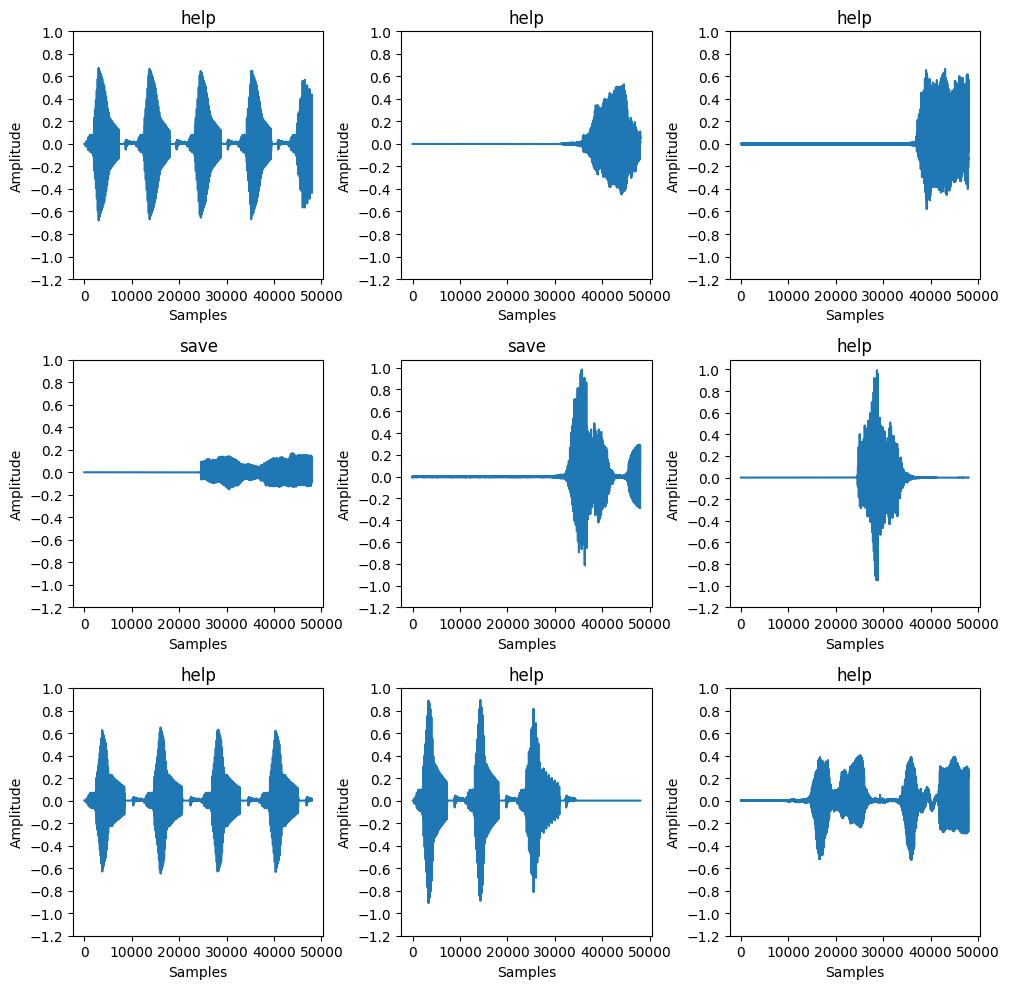

In [ ]:
# --- Plot some waveforms ---
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label_str = KEYWORDS[label.numpy()]
    ax.set_title(label_str)
    ax.set_xlabel("Samples")
    ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [ ]:
# Function to calculate MFCCs
def get_mfccs(waveform):
    # Zero-padding might be needed for STFT
    stfts = tf.signal.stft(waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP, fft_length=FRAME_LENGTH)
    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        NUM_MEL_BINS, num_spectrogram_bins, SAMPLE_RATE, LOWER_EDGE_HZ, UPPER_EDGE_HZ)
    mel_spectrograms = tf.tensordot(
        spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
        linear_to_mel_weight_matrix.shape[-1:]))

    # Compute MFCCs from log_mel_spectrograms
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
        log_mel_spectrograms)[..., :NUM_MFCC] # Take the first NUM_MFCC coefficients

    return mfccs

In [ ]:
# Function to combine waveform processing and feature extraction
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_mfccs(audio)
    # Add a `channels` dimension for CNN input
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram, label

In [ ]:
# --- Create feature dataset ---
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

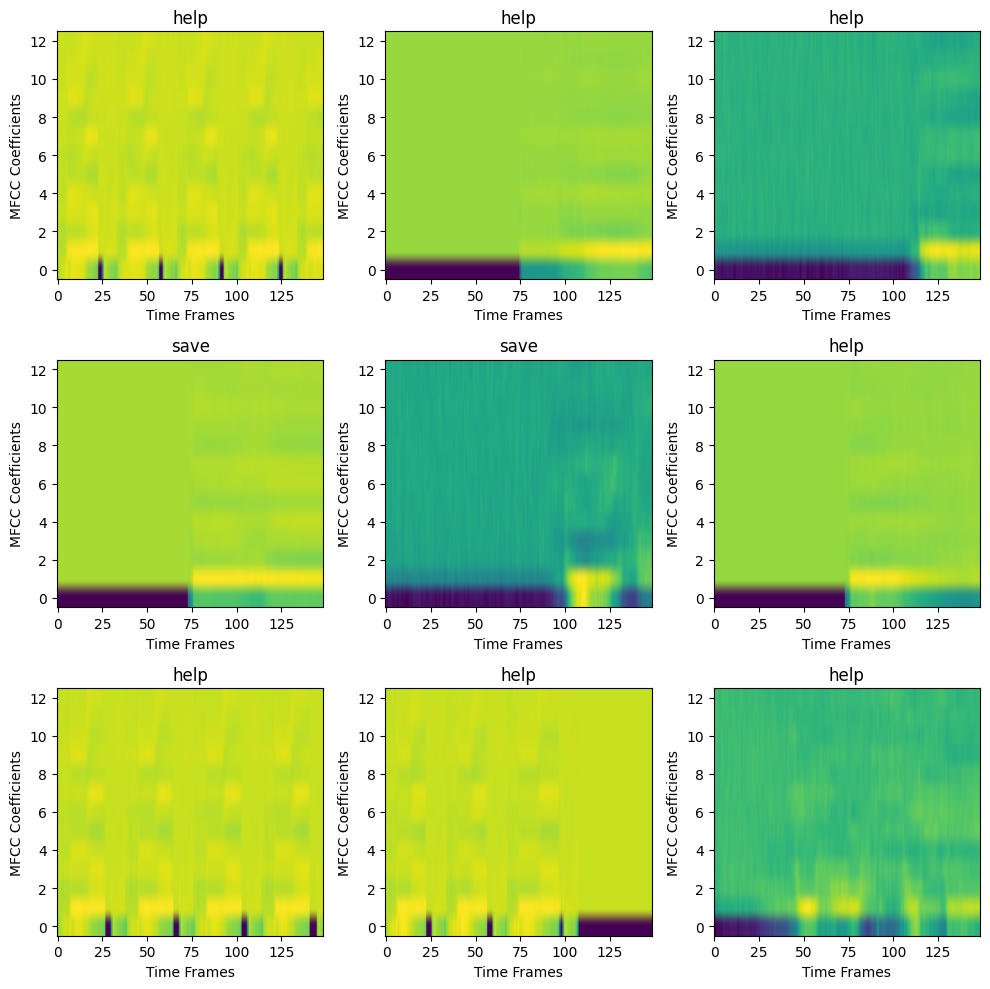

In [ ]:
# --- Plot some Spectrograms/MFCCs ---
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    # Plot the MFCCs (transpose for better visualization)
    img = ax.imshow(np.swapaxes(spectrogram.numpy().squeeze(), 0, 1), cmap='viridis', aspect='auto', origin='lower')
    ax.set_title(KEYWORDS[label_id.numpy()])
    ax.set_xlabel("Time Frames")
    ax.set_ylabel("MFCC Coefficients")
    # fig.colorbar(img, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

In [ ]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
# Batch the datasets
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

In [ ]:
# Add caching and prefetching for performance
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
# Determine the input shape for the model
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(KEYWORDS)


Input shape: (149, 13, 1)


In [ ]:
# Create a small batch of processed spectrograms for normalization
sample_spectrograms = []
for spectrogram, _ in spectrogram_ds.take(100):  # Take 100 samples
    sample_spectrograms.append(spectrogram.numpy())
sample_spectrograms = np.concatenate([s[np.newaxis, ...] for s in sample_spectrograms])

# Now adapt the normalization layer
norm_layer = layers.Normalization()
norm_layer.adapt(sample_spectrograms)

# The line below caused the error and should not be executed:
# norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Resizing to a common shape can sometimes help if input shapes vary slightly
    # layers.Resizing(32, 32), # Optional: Uncomment if needed
    norm_layer,
    layers.Conv2D(8, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    # layers.MaxPooling2D((2,2)), # Optional: Add another pooling if needed
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax') # Use softmax for multi-class classification
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (None, 149, 13, 1)     │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 149, 13, 8)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 6, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 74, 6, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 74, 6, 16)      │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 3, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 37, 3, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 37, 3, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 37, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3552)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       227,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,478 (912.03 KB)

 Trainable params: 233,475 (912.01 KB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)


In [ ]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, # Stop if val_loss doesn't improve for 5 epochs
                                                    restore_best_weights=True)

In [ ]:
# Optional: Save the best Keras model during training
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/keyword_ai_model/model/best_model.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
print("\n--- Starting Training ---")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping] # Add model_checkpoint here if using
)


--- Starting Training ---
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2927 - loss: 1.1768 - val_accuracy: 0.5349 - val_loss: 1.0378
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.5431 - loss: 1.0025 - val_accuracy: 0.6047 - val_loss: 1.0075
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6419 - loss: 0.9452 - val_accuracy: 0.6047 - val_loss: 0.9513
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5704 - loss: 0.9103 - val_accuracy: 0.6512 - val_loss: 0.8970
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5953 - loss: 0.9000 - val_accuracy: 0.7442 - val_loss: 0.8170
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5937 - loss: 0.8591 - val_accuracy: 0.6279 - val_loss: 0.8112
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6075 - loss: 0.8819 - val_accuracy: 0.7442 - val_loss: 0.7863
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6782 - loss: 0.7661 - val_accuracy

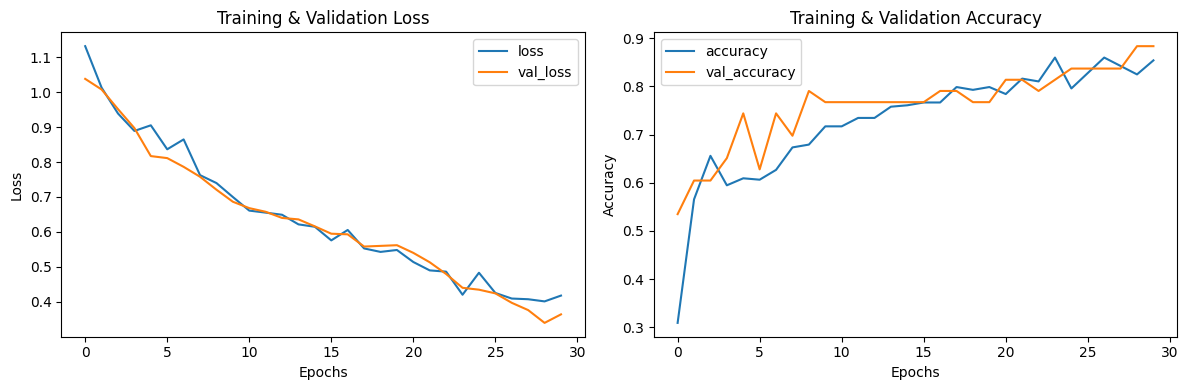

In [ ]:
# Plot training history
metrics = history.history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
# Corrected: Removed escape characters from keys
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["loss", "val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")

plt.subplot(1, 2, 2)
# Corrected: Removed escape characters from keys
plt.plot(history.epoch, metrics["accuracy"], metrics["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Evaluating on Test Set ---")
# Prepare the test dataset (no shuffling, batching)
test_audio = []
test_labels = []


--- Evaluating on Test Set ---


In [ ]:
for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


In [ ]:
# Evaluate using the Keras model
y_pred_probs = model.predict(test_audio)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_labels

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


In [ ]:
test_acc = sum(y_pred == y_true) / len(y_true)
print(f"Test set accuracy: {test_acc:.2%}")


Test set accuracy: 83.72%


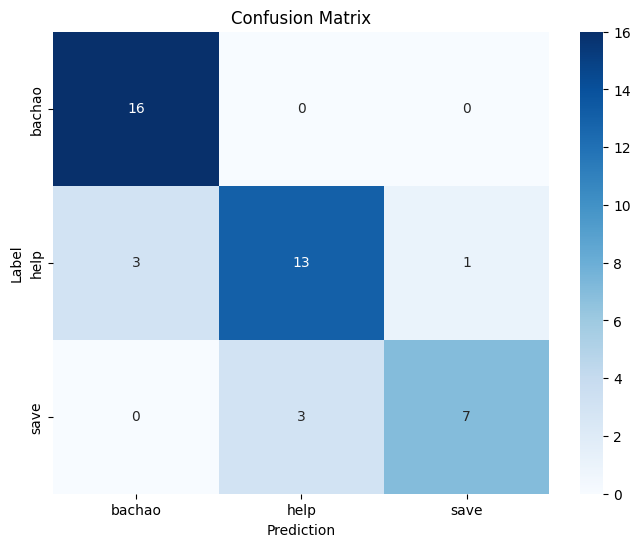

In [ ]:
# Confusion Matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, xticklabels=KEYWORDS, yticklabels=KEYWORDS,
            annot=True, fmt='g', # Corrected: Removed escape characters
            cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("\n--- Converting to TensorFlow Lite (Quantized) ---")

# Define the representative dataset generator for quantization
def representative_dataset_gen():
    # Use a small portion of the training data
    for input_value, _ in train_ds.take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)


--- Converting to TensorFlow Lite (Quantized) ---


In [ ]:
# Enable optimizations and specify supported types for integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
# Ensure that if ops can\t be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (or int8)
converter.inference_input_type = tf.int8 # or tf.uint8
converter.inference_output_type = tf.int8 # or tf.uint8

tflite_model_quant = converter.convert()

Saved artifact at '/tmp/tmpo6p4r33t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 149, 13, 1), dtype=tf.float32, name='keras_tensor_42')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133290620161488: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  133290620172816: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  133290620163792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133290620162256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133290620166480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133290620162832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133290620160336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133290620164176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133290620173776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133290620161104: TensorSpec(shape=(), dtype=tf.resource, name=No

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
# Save the quantized model
# Ensure the model directory exists
model_save_dir = "." # Save in the current Colab directory first
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [ ]:
tflite_model_path = os.path.join(model_save_dir, "keyword_model_quant.tflite")

In [ ]:
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model_quant)

print(f"Quantized TFLite model saved to: {tflite_model_path}")
print(f"Model size: {os.path.getsize(tflite_model_path) / 1024:.2f} KB")

Quantized TFLite model saved to: ./keyword_model_quant.tflite
Model size: 236.00 KB


In [ ]:
# 10. Test the TFLite Model

print("\n--- Testing TFLite Model ---")


--- Testing TFLite Model ---


In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()


In [ ]:
# Get input and output tensor details.
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

In [ ]:
# Check input type and quantization parameters
print("Input details:", input_details)
print("Output details:", output_details)

Input details: {'name': 'serving_default_keras_tensor_42:0', 'index': 0, 'shape': array([  1, 149,  13,   1], dtype=int32), 'shape_signature': array([ -1, 149,  13,   1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.5880236029624939, 82), 'quantization_parameters': {'scales': array([0.5880236], dtype=float32), 'zero_points': array([82], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Output details: {'name': 'StatefulPartitionedCall_1:0', 'index': 22, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [ ]:
# 11. Save Model & Notebook

print("\n--- Saving Final Artifacts ---")


--- Saving Final Artifacts ---


In [ ]:
# Instructions for user:
print(f"1. Download the quantized model: 	{tflite_model_path}")
print("   Place this file in your \"keyword_ai_model/model/\" directory.")
# Corrected: Removed escape characters from ".ipynb"
print("2. Save this Colab notebook (\".ipynb\" file).")
print("   Rename it to \"train_keyword_model.ipynb\" and place it in the root of your \"keyword_ai_model\" directory.")
print("3. Ensure your dataset is correctly placed in \"keyword_ai_model/dataset/\".")
print("4. Create the README.md file in the root of your \"keyword_ai_model\" directory.")

print("\n--- Notebook Execution Complete ---")

1. Download the quantized model: 	./keyword_model_quant.tflite
   Place this file in your "keyword_ai_model/model/" directory.
2. Save this Colab notebook (".ipynb" file).
   Rename it to "train_keyword_model.ipynb" and place it in the root of your "keyword_ai_model" directory.
3. Ensure your dataset is correctly placed in "keyword_ai_model/dataset/".
4. Create the README.md file in the root of your "keyword_ai_model" directory.

--- Notebook Execution Complete ---


In [ ]:
# Function to run inference with TFLite model
def run_tflite_inference(interpreter, input_data):
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Check if the input type is quantized (int8 or uint8)
    input_scale, input_zero_point = input_details["quantization"]

    # --- Debug Print: Input details ---
    print(f"    Input Details: {input_details}")
    print(f"    Input data shape before processing: {input_data.shape}, dtype: {input_data.dtype}")
    print(f"    Input Scale: {input_scale}, Input Zero Point: {input_zero_point}")


    if (input_details["dtype"] == np.int8):
        print("    Input is INT8. Applying quantization scale/zero point.")
        input_data = (input_data / input_scale) + input_zero_point
        if len(input_data.shape) == 3:
             input_data = np.expand_dims(input_data, axis=0)
        input_data = input_data.astype(np.int8)
        print(f"    Input data shape after quantization: {input_data.shape}, dtype: {input_data.dtype}")
        # print(f"    Sample input data slice after quantization: {input_data[0, 0, 0:10, 0]}") # Print a small slice if needed

    # Corrected: Removed escape characters from key access
    interpreter.set_tensor(input_details["index"], input_data)
    interpreter.invoke()
    # Corrected: Removed escape characters from key access
    output_data = interpreter.get_tensor(output_details["index"])

    # --- Debug Print: Output details and raw output ---
    print(f"    Output Details: {output_details}")
    print(f"    Raw output data shape: {output_data.shape}, dtype: {output_data.dtype}")
    # print(f"    Raw output data: {output_data}") # Careful printing this for many samples

    # Dequantize the output if needed
    output_scale, output_zero_point = output_details["quantization"]
    # Corrected: Removed escape characters from key access
    if (output_details["dtype"] == np.int8):
        print("    Output is INT8. Applying dequantization scale/zero point.")
        output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale
        print(f"    Output data shape after dequantization: {output_data.shape}, dtype: {output_data.dtype}")
        print(f"    Output data after dequantization: {output_data}") # Print dequantized output scores


    if output_data.shape[0] == 1:
        output_data = np.squeeze(output_data, axis=0)
        print(f"    Output data shape after squeezing batch: {output_data.shape}")
        print(f"    Final Output Scores (squeezed): {output_data}") # Print final scores


    return output_data

# Then run your TFLite testing loop for a few samples (e.g., 10 samples)
num_test_samples_debug = 25 # Reduce for debugging
tflite_predictions = []
actual_labels = []

for i in range(num_test_samples_debug):
    input_data_sample = np.expand_dims(test_audio[i], axis=0) # Get one sample and add batch dim
    actual_label = test_labels[i]
    actual_labels.append(actual_label)

    print(f"\n--- Running TFLite inference for Sample {i+1} (Actual Label: {KEYWORDS[actual_label]}) ---")

    # Pass the single sample (with batch dim) to the inference function
    output_data = run_tflite_inference(interpreter, input_data_sample)

    # output_data is already squeezed inside the function
    predicted_label = np.argmax(output_data) # Argmax on the squeezed output

    tflite_predictions.append(predicted_label)

    print(f"\n  Actual Label:    {KEYWORDS[actual_label]} ({actual_label})")
    print(f"  Predicted Label: {KEYWORDS[predicted_label]} ({predicted_label})")

# Calculate accuracy on these few samples (optional for debugging)
tflite_test_acc_debug = sum(np.array(tflite_predictions) == np.array(actual_labels)) / num_test_samples_debug
print(f"\nTFLite model accuracy on first {num_test_samples_debug} test samples: {tflite_test_acc_debug:.2%}")


--- Running TFLite inference for Sample 1 (Actual Label: bachao) ---
    Input Details: {'name': 'serving_default_keras_tensor_42:0', 'index': 0, 'shape': array([  1, 149,  13,   1], dtype=int32), 'shape_signature': array([ -1, 149,  13,   1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.5880236029624939, 82), 'quantization_parameters': {'scales': array([0.5880236], dtype=float32), 'zero_points': array([82], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
    Input data shape before processing: (1, 149, 13, 1), dtype: float32
    Input Scale: 0.5880236029624939, Input Zero Point: 82
    Input is INT8. Applying quantization scale/zero point.
    Input data shape after quantization: (1, 149, 13, 1), dtype: int8
    Output Details: {'name': 'StatefulPartitionedCall_1:0', 'index': 22, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_p